# ECE143 Individual Project
# Project Name: Communication Network (CommNet)
# Student: Xiaotian Wang
# PID: A53238781

## Description of this project

### 1. This project is using modular design paradigm, i.e., using functions instead of classes. 

### 2. Package version: Python: 2.7,  Numpy: 1.14.2, Matplotlib: 2.2.2

### 3. This project includes four parts: 

### Part 1 *Trimming Algorithm*:   
This part deals with how to trim a new tower area when a new tower is added. This is the core algorithm in this project. I build the trimming algorithm on top of an algorithm that finds the largest area in a histogram. This trimming algorithm is very efficient (time complexity: O(m * n), where m and n are width and height of new tower's pre-trimming coverage).

### Part 2 *Drawing Function*:
This drawing function takes towers' coordinates as input(untrimmed and trimmed), gives an animation of adding and trimming new towers using matplotlib. Towers are represented in different colors.

### Part 3 *Utilities*:
This part includes necessary utility functions to implement the working pipeline. For example, function to generate random new towers, function to check if the area is fully covered, function to plot analysis graph, etc..

### Part 4 *Solving Problems*:
**This part are functions that addresses three problems listed in project description. Graders can run functions in this part to see the solutions to these problems.**

### Part 5 *Discussion and Analysis*:
This part discuss the reason why I choose this algorithm and also give some analysis results about this coverage problem.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Part 1.  Triming Algorithm
### This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.


### In order to implement an efficient trimming, I take following steps:
+ Step 1. Write function **commNetSubtractOverlap**. Use the current tower area to minus overlapping area, resulting in a binary matrix of 0(occupied)/1(unoccupied);

+ Step 2. Write a subroutine **commNetLargeRectHist** to calculate the largest rectangle in a histogram;

+ Step 3. Write function **commNetLargeRect** on top of **commNetLargeRectHist** to find the largest rectangle in a binary matrix.

+ Step 4. Write function **commNetTrim** In this binary matrix, use **commNetLargeRect** to find the possible largest rectangle, and regard this rectangle as trimmed area of this new tower

+ Step 5. Write function **commNetTrimSequence**, use **commNetTrim** to deal with a sequence of new added towers, generating a sequence of trimmed towers.

#### Step 1
In the following function, I subtract the overlapping area from the new tower, resulting in a binary matrix of 0(occupied)/1(unoccupied);

In [2]:
def commNetSubtractOverlap(previous_binary_map, new_tower):
    """
    Subtract the overlapping area from the new tower.
    
    Params:
    -------
    1. previous_binary_map: 2-D numpy binary array. "1" is positions covered by previous towers, "0" is positions
    not covered by previous towers.
    2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Return:
    -------
    remain_area: A binary 2-D numpy array of 0(occupied)/1(unoccupied), the same size as new tower area.
    """
    
    (left_up_x, left_up_y, width, height) = new_tower
    remain_area = np.ones((width, height)).astype('int') - previous_binary_map[left_up_x : left_up_x+width, left_up_y : left_up_y+height]
    
    return remain_area


#### Step 2
In the following function, I am implementing an algorithm that returns the largest area in a histogram. The time complexity of this algorithm is O(n) where n is the width of the histogram. This implementation is inspired by the descritption of the algorithm in following link: https://www.geeksforgeeks.org/largest-rectangle-under-histogram/. I modified the original algorithm (add a "-1" bar at the beginning and at the end) in order to give a more general result and avoid discussing corner cases.

In [3]:
def commNetLargeRectHist(alist):
    """
    Implementation of an algorithm that returns the largest area in a histogram.
    
    Params:
    -------
    alist, a list of intergers representing a histogram.
    
    Return:
    -------
    left_index: int, left padded index(not included) of the largest rectangle;
    right_index: int, right padded index(not included) of the largest rectangle;
    height: int, height of the largest rectangle;
    largest_area: int, area of the largest rectangle.
    """
    
    full_list = [-1] + alist + [-1] # pad the original histogram with two "-1" bars, for consistency in algorithm
    index_list = list(range(len(full_list)))

    stk = []
    stk.append(0) # initialize the stack of indices, and put in the first element in padded list.
    # saved_rects = []
    largest_area = 0 # initialize the largest area to 0.
    left_index = 0
    right_index = 0
    height = 0

    i = 1 # initialize the pointer to position 1, i.e. the beginning of histogram

    while not (stk[-1]==0 and i==len(full_list)-1): 
        # Stop condition: the top of stack is zero AND we have reached the end of histogram
        # Note: before i reach the tail pad element(-1), the stack is not empty(i.e. stk[-1]!=0)
        
        if full_list[i] >= full_list[stk[-1]]: # If this bar is larger than/equal to the top bar in the stack
            stk.append(i) # put this bar in stack
            i += 1 # evaluate the next bar in histogram

        else: # If this bar is smaller than the top bar in the stack
            this_height = full_list[stk.pop()] # pop the top bar in the stack, and use its value as height of rectangle
            this_left_index = stk[-1] # left and right indices are used to calculate width of rectangle
            this_right_index = i
            this_area = (this_right_index - this_left_index - 1) * this_height
            # saved_rects.append((this_height, this_left_index, this_right_index, this_area))
            if this_area > largest_area: # store data if this area is the largest so far
                largest_area = this_area
                left_index = this_left_index
                right_index = this_right_index
                height = this_height
    # print saved_rects

    return {'largest_area': largest_area, 'left_index': left_index, 'right_index': right_index, 'height': height}

#### Step 3
The following function, *commNetLargeRect()* is written to find the possible largest rectangle in the *remain_area* returned by *commNetSubtractOverlap()*, and I regard this rectangle as trimmed area of this new tower. This algorithm is inspired by https://www.geeksforgeeks.org/maximum-size-rectangle-binary-sub-matrix-1s/, "The idea is to update each column of a given row with corresponding column of previous row and find largest histogram area for  that row."(quoted from this webpage).

In [4]:
def commNetLargeRect(remain_area, new_tower):
    """
    Find the possible largest rectangle in the remain_area returned by commNetSubtractOverlap().
    
    Params:
    -------
    1. remain_area: A binary 2-D numpy array of 0(occupied)/1(unoccupied), the same size as new tower area.
    2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Return:
    -------
    trimmed_area: a tuple of 4 integers, (tm_left_up_x, tm_left_up_y, tm_width, tm_height)
    """
    
    (left_up_x, left_up_y, width, height) = new_tower
    
    rows = np.shape(remain_area)[0]
    cols = np.shape(remain_area)[1]
    padded_area = np.vstack((np.zeros((1, cols)).astype('int'), remain_area)) # pad a zero row, avoiding discussing corner case
    tm_row = 0
    tm_width = 0
    tm_height = 0
    tm_left_index = 0
    tm_right_index = 1
    
    
    tm_largest_area = 0
    for row_index in range(1, rows+1):
        area_mask = np.copy(padded_area[row_index, :]) # a 0/1 mask
        padded_area[row_index, :] += padded_area[row_index-1, :] # add values of previous row to this row
        padded_area[row_index, :] = padded_area[row_index, :] * area_mask
        largest_rect = commNetLargeRectHist(list(padded_area[row_index, :])) # calculate largest rectangle in histogram
        if largest_rect['largest_area'] > tm_largest_area:
            tm_largest_area = largest_rect['largest_area']
            tm_left_index = largest_rect['left_index']
            tm_right_index = largest_rect['right_index']
            tm_width = largest_rect['height'] # width is "height" of histogram, horizontal axis in printing is the vertical axis in numpy array
            tm_row = row_index
    
    # calculate the position of trimmed area in the big picture
    tm_left_up_x = left_up_x + tm_row - tm_width 
    tm_left_up_y = left_up_y + tm_left_index
    
    tm_height = tm_right_index - tm_left_index - 1 # height is "width" of histogram, vertical axis in printing is the horizontal axis in numpy array
    
    trimmed_area = (tm_left_up_x, tm_left_up_y, tm_width, tm_height)
    
    return trimmed_area

#### Step 4
The following function is the "sum up" function of trimming algorithm, using *commNetLargeRect()* and *commNetSubtractOverlap()* as subroutines.

In [5]:
def commNetTrim(previous_binary_map, new_tower):
    """
    determain how to choose and retain an area when a new tower is posed on the map.
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    """
    remain_area = commNetSubtractOverlap(previous_binary_map, new_tower)
    new_tower_trimmed = commNetLargeRect(remain_area, new_tower)
    
    (tm_left_up_x, tm_left_up_y, tm_width, tm_height) = new_tower_trimmed
    new_binary_map = np.copy(previous_binary_map)
    new_binary_map[tm_left_up_x : tm_left_up_x+tm_width, tm_left_up_y : tm_left_up_y+tm_height] += 1
    
    return new_binary_map, new_tower_trimmed

#### Step 5
The following function use *commNetTrim()* to deal with a sequence of new added towers, generating a sequence of trimmed towers

In [6]:
def commNetTrimSequence(total_area, new_towers):
    """
    Generating a sequence of trimmed towers given total area and a sequence of new towers.
    
    Inputs:
        1. total_area: a tuple of 2 integers, (total_width, total_height). 
        2. new_towers: a list of tuples of 4 integers, (left_up_x, left_up_y, width, height)
    
    Outputs:
        trimmed_towers: a list of tuples of 4 integers, (tm_left_up_x, tm_left_up_y, tm_width, tm_height)
    """
    
    trimmed_towers = []
    new_binary_map = np.zeros(total_area).astype('int') # initialize map as all zeros
    
    for new_tower in new_towers:
        previous_binary_map = np.copy(new_binary_map)
        remain_area = commNetSubtractOverlap(previous_binary_map, new_tower)
        new_tower_trimmed = commNetLargeRect(remain_area, new_tower)
        trimmed_towers.append(new_tower_trimmed)

        (tm_left_up_x, tm_left_up_y, tm_width, tm_height) = new_tower_trimmed
        new_binary_map = np.copy(previous_binary_map)
        new_binary_map[tm_left_up_x : tm_left_up_x+tm_width, tm_left_up_y : tm_left_up_y+tm_height] += 1
    
    return new_binary_map, trimmed_towers

## Part 2. Drawing Function
### This function gives an animation of adding and trimming new towers using matplotlib.

In [7]:
def commNetDraw(total_area, new_towers, trimmed_towers=None, wait_time_1=0.4, wait_time_2=0.01, plot_trim=False):
     
    """
    This component is for printing an animation of adding and trimming towers given a sequence new towers and corresponding trimmed towers.
    
    Inputs: 
        1. new_towers: A list of tuples of 4 integers(left_up_x, left_up_y, width, height), representing new tower areas.
        2. trimmed_towers: A list of tuples of 4 integers(tm_left_up_x, tm_left_up_y, tm_width, tm_height), representing trimmed tower areas.
        3. total_area: a tuple of 2 integers, (total_width, total_height).
    
    Output:
        A animation, that the plotting pauses once a new tower area is added/trimmed.
    """
    %matplotlib notebook
    plt.rc('font', size=15)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.set_aspect('equal')

    max_width, max_height = total_area
    ax.set_xlim(0, max_width)
    ax.set_ylim(0, max_height)
    colors = ['r', 'g', 'b', 'c', 'y']
    c = 0

    fig.canvas.draw()
        
    for ind in range(len(new_towers)):

        # add original tower (before trimming) and plot
        (left_up_x, left_up_y, width, height) = new_towers[ind]
        p = patches.Rectangle((left_up_x, left_up_y), width, height, alpha = 0.5, color=colors[c])    
        ax.add_patch(p)
        fig.canvas.draw()
        time.sleep(wait_time_1)
    
        if plot_trim==True: # if we need to plot trimmed towers

            # remove original tower and plot
            p.remove()
            fig.canvas.draw()
            time.sleep(wait_time_2)

            # add trimmed tower and plot
            (tm_left_up_x, tm_left_up_y, tm_width, tm_height) = trimmed_towers[ind]
            q = patches.Rectangle((tm_left_up_x, tm_left_up_y), tm_width, tm_height, alpha = 0.5, color=colors[c])
            ax.add_patch(q)
            fig.canvas.draw()
            time.sleep(wait_time_1)

        # change color for next tower
        c += 1
        if c == len(colors):
            c = 0
                

## Part3 Utilities
### This part includes necessary utility functions to implement the working pipeline.

### Function 1. Tower Generating
#### This component generates a random tower.

In [8]:
def commNetGenTower(total_area):
    """
    Generates a random tower.
    
    Inputs:
    total_area: a tuple of 2 integers, (total_width, total_height).

    Outputs:
    new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    """
    total_width, total_height = total_area
    left_up_x = np.random.randint(0, total_width)
    left_up_y = np.random.randint(0, total_height)
    width = np.random.randint(1, total_width-left_up_x+1)
    height = np.random.randint(1, total_height-left_up_y+1)
    new_tower = (left_up_x, left_up_y, width, height)
    
    return new_tower

### Function 2. Covered ratio checking
#### This function checks if the area is fully covered, also calculates fraction of coverage.

In [9]:
def commNetCountCoveredArea(binary_map):
    """
    Count covered area ratio and judge if all area is coverd
    
    Input: 
        binary_map: a binary numpy 2-D array.
    Output:
        full: bool. whether the map is totally covered.
        ratio: float. covered area ratio.
    """
    full = False
    covered = np.count_nonzero(binary_map)
    total = binary_map.size
    if covered == total:
        full = True
    ratio = covered*1.0 / total
    
    return full, ratio

## Part 4 Solving Problems

## Function to solve problem 1 and 2: 

**1. Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?**

**2. What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?**

### The following function will give an animation of how we get the resolved coverage and print out the final fraction of coverage after the animation.

In [114]:
def commNetProblem1and2(total_area, new_towers=None, generate_towers=-1, show_animation=True, print_fraction=True):
    """
    This function is used for solving problem 1 and 2. 
    i.e., calculate and visualize a resolved coverage and calculate final fraction of coverage.
    
    Inputs:
    1. total_area: a tuple of 2 integers, (total_width, total_height).
    2. new_towers: a list of tuples of 4 integers(left_up_x, left_up_y, width, height), representing new tower areas.
    
    Outputs:
    1. an animation of resolved coverage.
    2. print a sentence describing the final fraction of coverage.
    
    """
    assert isinstance(total_area, tuple)
    assert isinstance(new_towers, (list, type(None)))
    assert isinstance(generate_towers, int)
    assert isinstance(show_animation, bool)
    assert isinstance(print_fraction, bool)
    
    assert isinstance(total_area[0], int)
    assert isinstance(total_area[1], int)
    
    assert generate_towers > 0
    assert total_area[0] > 0
    assert total_area[1] > 0
    
    if generate_towers>0: # instead of taking new towers as input, this funtion can also generate random new towers
        new_towers = []
        for i in range(generate_towers):
            new_towers.append(commNetGenTower(total_area))
    
    # calculate and visualize a resolved coverage
    new_binary_map, trimmed_towers = commNetTrimSequence(total_area, new_towers)
    
    if show_animation:
        commNetDraw(total_area, new_towers, trimmed_towers=trimmed_towers, plot_trim=True)
    
    # calculate final fraction of coverage
    full, ratio = commNetCountCoveredArea(new_binary_map)
    
    if print_fraction:
        if full:
            print "Totally covered, no gap in coverage."
        else:
            print "Not fully covered, covered ratio: {0}".format(ratio)
        
    return new_binary_map, full, ratio

### Test case 1: giving total footprint and a list of new towers.

<IPython.core.display.Javascript object>


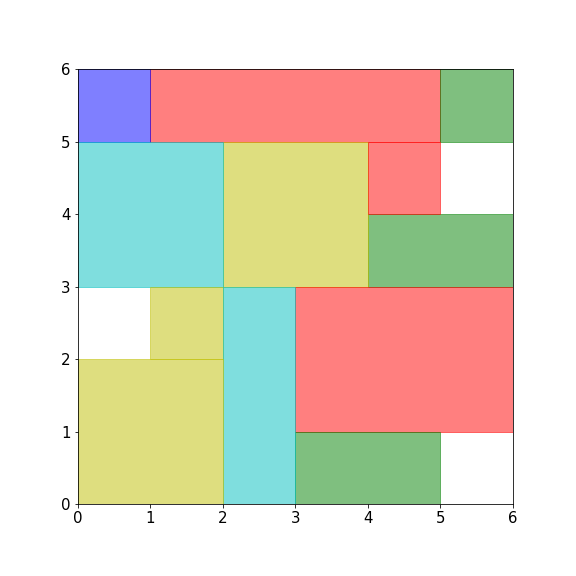

Not fully covered, covered ratio: 0.916666666667


<IPython.core.display.Javascript object>


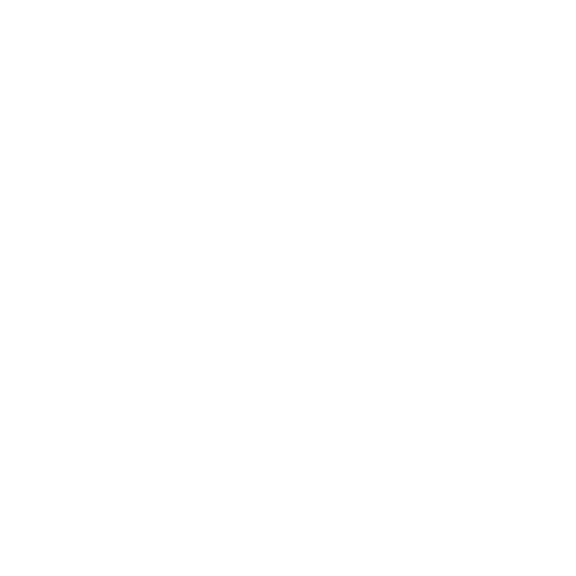

In [106]:
eg_total_area = (6, 6)

eg_towers = [(1, 5, 4, 1),
 (4, 3, 2, 1),
 (0, 5, 4, 1),
 (1, 5, 2, 1),
 (2, 3, 4, 3),
 (3, 1, 3, 2),
 (4, 5, 2, 1),
 (5, 2, 1, 2),
 (0, 3, 4, 3),
 (1, 2, 1, 3),
 (1, 3, 4, 3),
 (3, 0, 2, 2),
 (0, 5, 3, 1),
 (2, 0, 3, 3),
 (1, 5, 2, 1),
 (3, 5, 2, 1),
 (5, 2, 1, 1),
 (4, 5, 2, 1),
 (1, 5, 5, 1),
 (0, 0, 5, 5)]

new_binary_map, full, ratio = commNetProblem1and2(total_area=eg_total_area, new_towers=eg_towers)

### Test case 2: giving total footprint and the number of new towers.
### In this case, the function will generate random towers.

<IPython.core.display.Javascript object>


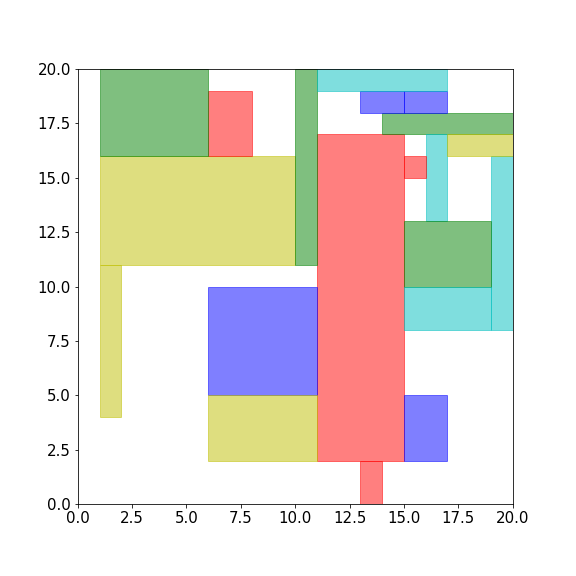

Not fully covered, covered ratio: 0.6175


<IPython.core.display.Javascript object>


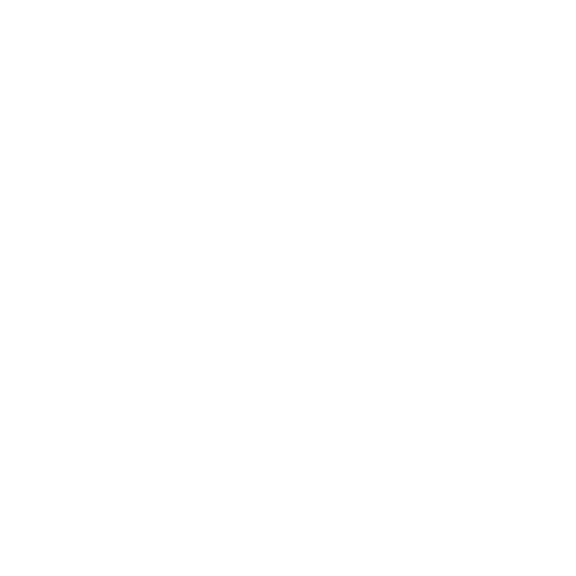

In [108]:
new_binary_map, full, ratio = commNetProblem1and2(total_area=(20, 20), generate_towers=20)

### feel free to change numbers of "total_area" and "generate_towers".

<IPython.core.display.Javascript object>


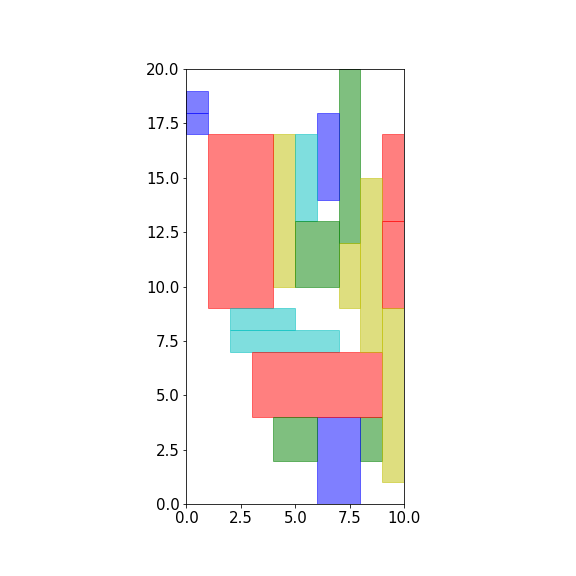

Not fully covered, covered ratio: 0.61


<IPython.core.display.Javascript object>


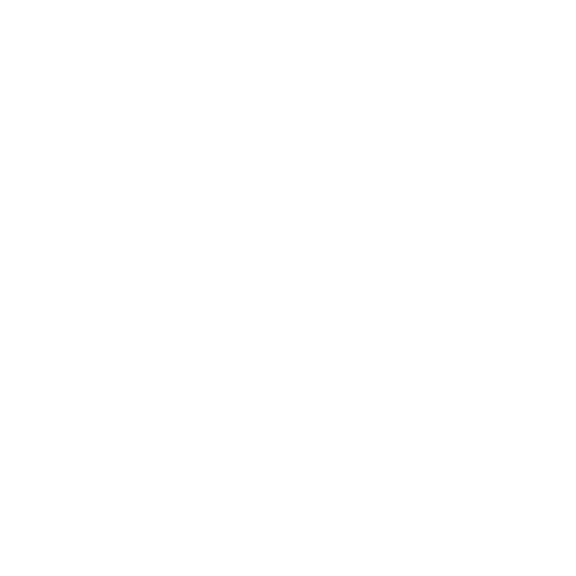

In [115]:
new_binary_map, full, ratio = commNetProblem1and2(total_area=(10, 20), generate_towers=20)

## Function to solve problem 3: 
**3. On average, how many communications towers are required before full coverage is obtained?**

In [110]:
def commNetProblem3(total_area=eg_total_area, tries=20, print_result=True):
    """
    This function solves problem 3, 
    i.e.,given the total footprint, 
    return the average number of communications towers that are required before full coverage is obtained.
    
    Inputs:
    1. total_area: a tuple of 2 integers, (total_width, total_height).
    2. tries: int, number of times of experiments (to calculate average).
    """
    
    assert isinstance(total_area, tuple)
    assert isinstance(tries, int)
    assert isinstance(print_result, bool)
    
    assert isinstance(total_area[0], int)
    assert isinstance(total_area[1], int)
    
    num_tower = []
    
    for i_tries in range(tries):
    
        new_binary_map = np.zeros(total_area).astype('int') # initialize map as all zeros
        ratio = 0
        full = False

        new_towers = []
        trimmed_towers = []

        while not full:
            previous_binary_map = np.copy(new_binary_map)
            new_tower = commNetGenTower(total_area)
            new_towers.append(new_tower)
            new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)
            trimmed_towers.append(new_tower_trimmed)
            full, ratio = commNetCountCoveredArea(new_binary_map)
        
        num_tower.append(len(new_towers))

        # commNetDraw(total_area, new_towers, trimmed_towers=trimmed_towers, plot_trim=True)
        
    avg_tower = sum(num_tower) * 1.0 / tries
    
    if print_result:
        print "On average, {0} communications towers are required before full coverage is obtained for this total area".format(avg_tower)
    
    return avg_tower

### Test case 1: give a footprint and number of experiments

In [111]:
avg_tower = commNetProblem3((10, 10), 10)

On average, 130.4 communications towers are required before full coverage is obtained for this total area


You can also try:

In [112]:
avg_tower = commNetProblem3((20, 20), 10)

On average, 572.0 communications towers are required before full coverage is obtained for this total area


In [113]:
avg_tower = commNetProblem3((14, 14), 100)

On average, 324.92 communications towers are required before full coverage is obtained for this total area


## Part 5 Discussion and Analysis

### Discussion: Why I choose this "stack-based" algorithm?

The core algorithm implemented in this project is a **"stack-based" algorithm** to find largest rectangle in the "remain_area" of a new tower after subtracting overlapped regions.


At the beginning, I was trying a **brute force** method to search every possible rectangles in the "remain_area". However, it turns out that the time complexity of this algorithm is unacceptable. Considering a new tower's coverage is (width \* height) = (m \* n):

If we use brute force search:
    1. we need to iterate over every element in this area as "left up corner". (~ m * n)
    2. on top of previous iteration, we need to iterate over 1 to m as width of found rectangle. (~ m)
    3. on top of previous iterations, we need to iterate over 1 to n as length of found rectangle. (~ n)
    In total the time complexity is O((m * n) ^ 2).
If we use this stack-based search:
    1. In the process of finding largest histogram in every row, every element in this row is put in and popped out of the stack for only once. (~ m).
    2. We scan the rows for just once, for every row we calculate the possible largest histogram as the possible largest rectangle. (~ n)
    In total the time complexity is O(m * n)
From above discussion we can see how much time stack-based search can save for us.

### Analysis 1: fraction of coverage vs number of towers

The following analysis considers maps (5, 5), (8, 8), (11, 11), (14, 14), (17, 17). For each map, I tried number of towers from 10 to 50, every choice with 100 tries to compute average. The result is shown as a plot with mutiple lines, each line representing a map.

In [63]:
def commNetCoverageVNoftowers():
    results = np.zeros((5, 5))
    maps = ((5, 5), (8, 8), (11, 11), (14, 14), (17, 17))
    noftowers = (10, 20, 30, 40, 50)
    for ind_map, footprint in enumerate(maps):
        # print "new map"
        for ind_tower, tower in enumerate(noftowers):
            # print "new tower"
            coverages = np.zeros((100,))
            for i in range(100):
                _, _, ratio = commNetProblem1and2(footprint, new_towers=None, generate_towers=tower, 
                                                  show_animation=False, print_fraction=False)
                coverages[i] = ratio
            results[ind_map, ind_tower] = np.mean(coverages)
    
    return results

In [65]:
def commNetCoverageVNoftowersPlot(results):
    
    maps = ((5, 5), (8, 8), (11, 11), (14, 14), (17, 17))
    noftowers = (10, 20, 30, 40, 50)
    
    %matplotlib inline
    plt.rc('font', size=15)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    
    x_list = list(noftowers)
    for ind_map, footprint in enumerate(maps):
        y_list = list(results[ind_map, :])
        ax.plot(x_list, y_list, marker = 'o')
    plt.legend(map(lambda x : str(x), maps))
    plt.title("Fraction of Coverage vs Number of Towers")
    plt.xlabel('number of towers', fontsize=18)
    plt.ylabel('fraction of coverage', fontsize=16)
    plt.show()

### The following line do the above analysis and plot a figure to show the results
#### Note: it takes ~10 sec to run this line

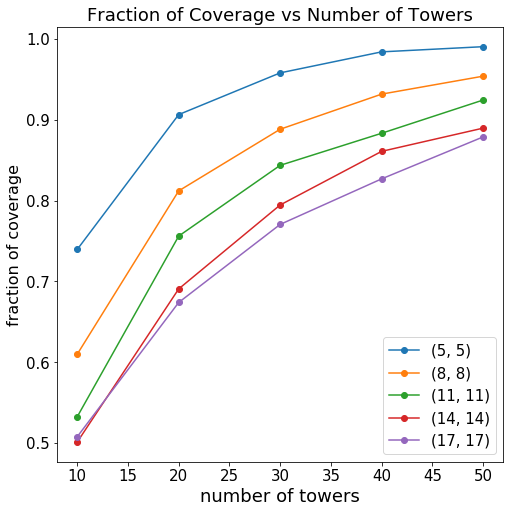

In [68]:
commNetCoverageVNoftowersPlot(commNetCoverageVNoftowers())

### Analysis 2: heatmap of number of towers to achieve full coverage

The following analysis considers maps whose width and height changes from 5 to 14. 
For each map, I tried 100 times to calculate their required number of towers to achieve full coverage, and then take average over 100 attemps. The final result is shown as a heatmap.

In [93]:
def commNetNoftowersFull():
    
    results = np.zeros((10, 10))
    m_widths = range(5, 15)
    m_heights = range(5, 15)
    for height_ind, m_height in enumerate(m_heights):
        # print "new height"
        for width_ind, m_width in enumerate(m_widths):
            # print "new width"
            avg_tower = commNetProblem3((m_width, m_height), 100, print_result=False)
            results[width_ind, height_ind] = avg_tower

    return results

In [94]:
def commNetNoftowersFullPlot(results):

    %matplotlib inline
    plt.rc('font', size=15)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    cax = ax.matshow(results)
    fig.colorbar(cax)

    alpha = map(lambda x : str(x), range(5, 14, 2))
    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)
    plt.title("heatmap of towers to achieve full coverage")
    plt.xlabel('height')
    plt.ylabel('width')

    plt.show()

### The following line do the above analysis and plot a heatmap to show the results
### Note: it takes ~3 min to run this line

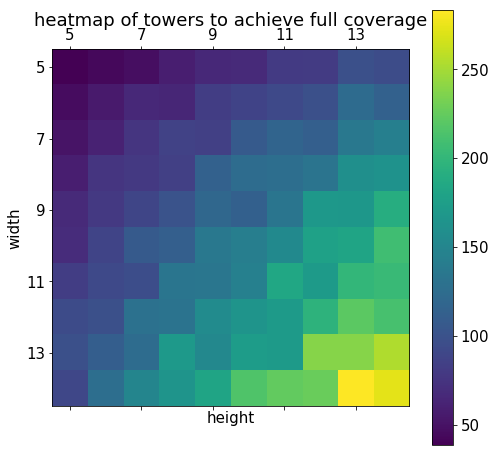

In [95]:
commNetNoftowersFullPlot(commNetNoftowersFull())